In [46]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

from seaborn import heatmap

sns.reset_defaults()
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

In [47]:
# for each node in a network, find the degree of its neighbors and take the average
# stores the degree and average neighbor degree in a dataframe
def get_avg_nn_degree(network):
    degrees = network.degree
    degree = []
    k_nearest_neighbors = []
    for i in network.nodes:
        k_i = degrees[i]
        if k_i > 0:
            network.nodes[i]['degree'] = k_i
            k_nn = sum([degrees[j] for j in network.neighbors(i)]) / k_i
            network.nodes[i]['avg_knn'] = k_nn
            degree.append(k_i)
            k_nearest_neighbors.append(k_nn)
        else:
            network.nodes[i]['degree'] = 0
            network.nodes[i]['avg_knn'] = 0
            degree.append(0)
            k_nearest_neighbors.append(0)
    return pd.DataFrame({'degree': degree, 'average_nearest_neighbor_degree': k_nearest_neighbors})

In [48]:
# for each network in the ensemble dataframe, gets the average nearest neighbor
# degree and puts it all in a dataframe
def get_avg_nn_degree_null(ensemble):
    network_nos = ensemble['network_no'].unique()
    null_nn = pd.DataFrame(columns=['degree', 'average_nearest_neighbor_degree'])
    for i in network_nos:
        null_edge_list = ensemble.loc[ensemble['network_no'] == i]
        null_network = nx.from_pandas_edgelist(null_edge_list, source='source', target='target')
        new_rows = get_avg_nn_degree(null_network)
        null_nn = pd.concat([null_nn, new_rows])
    return null_nn


### Finding line of best fit and $\mu$ for $k_{nn}(k)$:
For a non-neutral network, the line that best fits $k_{nn}(k)$ is given by: :
\begin{align}
k_{nn}(k) = ak^{\mu}
\end{align}
We need to find the values $a, \mu$ that best fit the data. Taking the logarithm of both sides gives us:
\begin{align}
log(k_{nn}(k)) &= log(ak^{\mu}) \\
&= log(a) + \mu log(k)
\end{align}
let:
- $K_{NN}(K) = log(k_{nn}(k))$
- $K = log(k)$
- $A = log(a)$

Substituting in these variables gives us a linear equation of the form:
\begin{align}
K_{nn}(K) = A + \mu K
\end{align}
We can use linear regression to find the values for $\mu$ and $A$, and find $a$ by using $a=10^A$.


In [49]:
def find_line(nn_df):
    # transform k and k_nn
    log_k = np.log10(nn_df['degree'].values)
    log_knn = np.log10(nn_df['average_nearest_neighbor_degree'].values)
    # add constant term for intercept (A)
    log_k = sm.add_constant(log_k)
    # Fit the model
    model = sm.OLS(log_knn, log_k).fit()

    return model

In [50]:
# Draws the k nearest neighbours plot
# def draw_knn(network, dp, rgg, genre, model):
def draw_knn(network, genre, model, ax, palette, l):
    # Extract model parameters
    A, mu = model.params
    a = 10**A

    # get confidence interval for mu
    cis = model.conf_int()
    mu_ci = cis[1]
    mu_moe = mu_ci[1] - mu

    # Get coordinates for line of best fit
    line_x = [k for k in network['degree'].unique()]
    line_y = [a * (x**mu) for x in line_x]

    # Group the network nearest neighbours by degree to make the scatterplot less cluttered
    network_avgs = network.groupby('degree')['average_nearest_neighbor_degree'].mean()
    max_degree = max(network_avgs.index)

    # fig, ax = plt.subplots(dpi=300)
    ax.set(xscale='log',
           yscale='log',
           # xlim=(0,max_degree + 5),
           # ylim=(0,120),
           # xlabel='$ k $',
           ylabel = '$ k_{nn}(k) $',
           title=genre)
           # title=f'Average nearest neighbor degree for {genre} genre')

    sns.lineplot(x=line_x,
                 y=line_y,
                 ax=ax,
                 label = fr'$ {a:.2f}k^{{{mu:.2f}}} $, $ \mu = {mu:.2f} \pm {mu_moe:.2f} $',
                 alpha=.8,
                 color = palette[l])

    sns.scatterplot(x=network_avgs.index,
                              y=network_avgs.values,
                              ax=ax,
                              label = 'real network',
                              linewidth=.2,
                              s = 15,
                              alpha = 1,
                              color= palette[9 - l])

    # Draw nearest neighbor degree lines for null model ensembles
    # sns.lineplot(data=dp, x='degree', y='average_nearest_neighbor_degree', ax=ax, err_style='band', errorbar='sd', label = 'degree preserving model')
    # sns.lineplot(data=rgg, x='degree', y='average_nearest_neighbor_degree', ax=ax, err_style='band', errorbar='sd', label = 'random geometric model')
    # Draw line of best fit for network k_nn


    ax.legend(prop={'size': 6})
    # fig.savefig(f'./plots/k_nearest_neighbors/{genre}_knn.png')

    # plt.show()

In [51]:
def get_degree_probabilities_and_plot(network: nx.Graph, genre):
    max_degree = max(k for node, k in network.degree())
    degree_count_matrix = np.zeros(shape=(max_degree, max_degree))
    degrees = network.degree

    # j = row
    # k = column
    # For every edge in the network, count the number of times a node with degree j
    # is connected to a node with degree k
    for e in network.edges:
        j = degrees[e[0]] - 1
        k = degrees[e[1]] - 1
        degree_count_matrix[j, k] += 1

    # divide by the total number of edges to get a probability distribution
    degree_probability_matrix = degree_count_matrix / network.number_of_edges()

    # Convert matrix data to a dataframe so that we can make a heatmap
    source_degree = []
    target_degree = []
    p = []
    for j in range(max_degree):
        for k in range(max_degree):
            source_degree.append(j)
            target_degree.append(k)
            p.append(degree_probability_matrix[j, k])
    fig, ax = plt.subplots(dpi=300)
    heatmap_df = pd.DataFrame({'source degree $ j $': source_degree, 'target degree $ k $': target_degree, '$ e_{jk} $': p}) \
                   .pivot(index = 'source degree $ j $', columns = 'target degree $ k $', values = '$ e_{jk} $')

    ax.set(title=f'Degree probability matrix for edges in the {genre} genre network\n',
           xlabel='target degree $ j $',
           ylabel='source degree $ k $')

    sns.heatmap(heatmap_df,
                cbar_kws={'label': '$ e_{jk} $'},
                ax=ax,
                cmap='mako',
                xticklabels=10,
                yticklabels=10)


    fig.savefig(f'./plots/heatmap/{genre}_heatmap.png')
    plt.show()

    return degree_probability_matrix

In [52]:
# computes the assortativity coefficient r from the lecture on null models
def compute_r(prob_matrix):
    size = len(prob_matrix[0])
    q_j = np.sum(prob_matrix, axis=1)
    q_k = np.sum(prob_matrix, axis=0)
    differences = np.sum([(j*k)*(prob_matrix[j][k] - (q_j[j] * q_k[k])) for j in range(size) for k in range(size)])
    sigma = (np.sum([(k**2) * q_k[k] for k in range(size)])) - (np.sum([k * q_k[k] for k in range(size)])**2)
    return differences/sigma

In [53]:
def degree_correlation_metrics():
    genres = ['blues', 'classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
    metrics_df = pd.DataFrame(columns = ['genre', 'a', 'mu', 'mu MoE', 'r'])
    fig, axs = plt.subplots(dpi=300, nrows=5, ncols=2, figsize=(8.5,11), sharex=True, sharey=True)
    l = 0
    palette = sns.color_palette('viridis', 10)
    for genre in genres:
        # ensemble_dp = pd.read_csv(f"../null-model-ensembles/networks/degree_preserving/{genre}_dp.csv")
        # ensemble_rgg = pd.read_csv(f"../null-model-ensembles/networks/random_geometric/{genre}_rgg.csv")

        edge_list = pd.read_csv(f"../networks/{genre}_edge_list.csv").rename(columns={"Node1": "source", "Node2": "target"})
        network = nx.from_pandas_edgelist(edge_list, source='source', target='target')

        network_nn = get_avg_nn_degree(network)
        # dp_nn = get_avg_nn_degree_null(ensemble_dp)
        # rgg_nn = get_avg_nn_degree_null(ensemble_rgg)

        model = find_line(network_nn)
        A, mu = model.params
        a = 10**A

        # get confidence interval for mu
        cis = model.conf_int()
        mu_ci = cis[1]
        mu_moe = mu_ci[1] - mu

        i = int (l / 2)
        j = l % 2
        current_ax = axs[i][j]

        # draw graphs, and add degree correlation metrics to dataframe
        # draw_knn(network_nn, dp_nn, rgg_nn, genre, model)
        scatter = draw_knn(network_nn, genre, model, current_ax, palette, l)
        degree_probability_matrix = get_degree_probabilities_and_plot(network, genre)
        r = compute_r(degree_probability_matrix)

        metrics_df.loc[metrics_df.shape[0],:] = [genre, a, mu, mu_moe, r]

        l += 1

    metrics_df.to_csv('degree_correlation_metrics.csv', index=False)

    axs[4][0].set(xlabel='degree $ k $')
    axs[4][1].set(xlabel='degree $ k $')
    fig.savefig(f'./plots/k_nearest_neighbors/all_genres_knn.png')


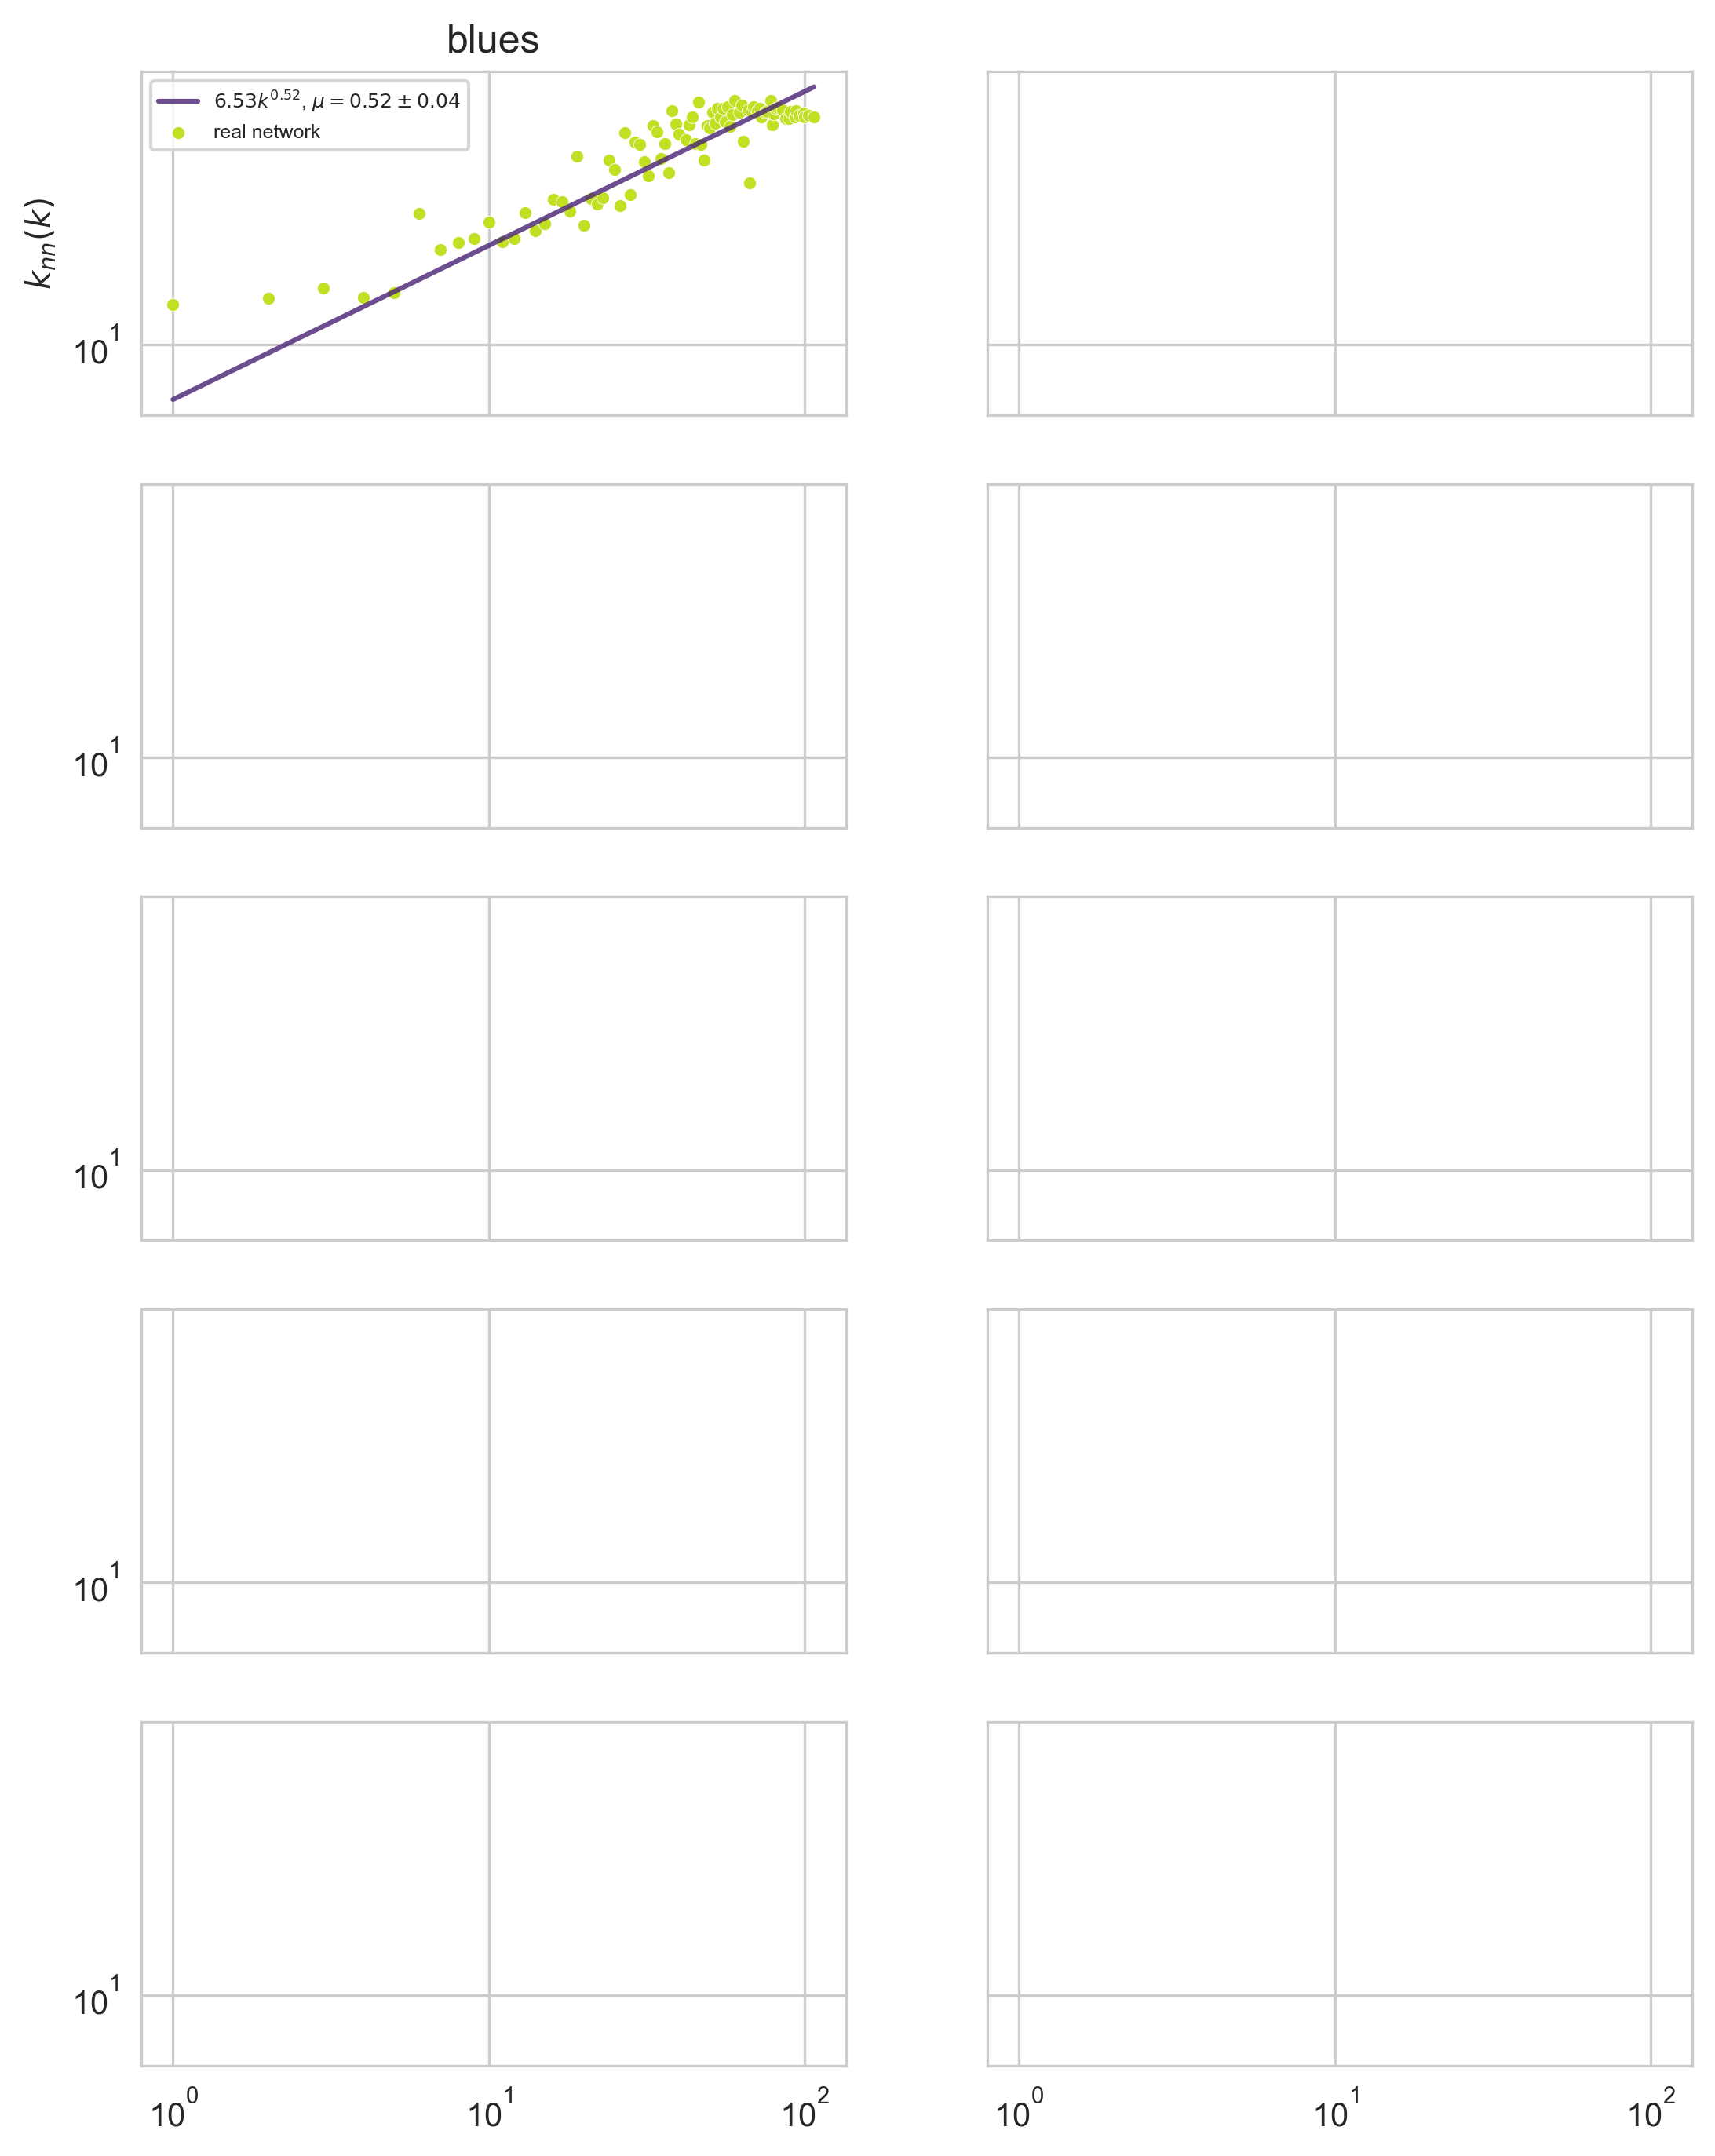

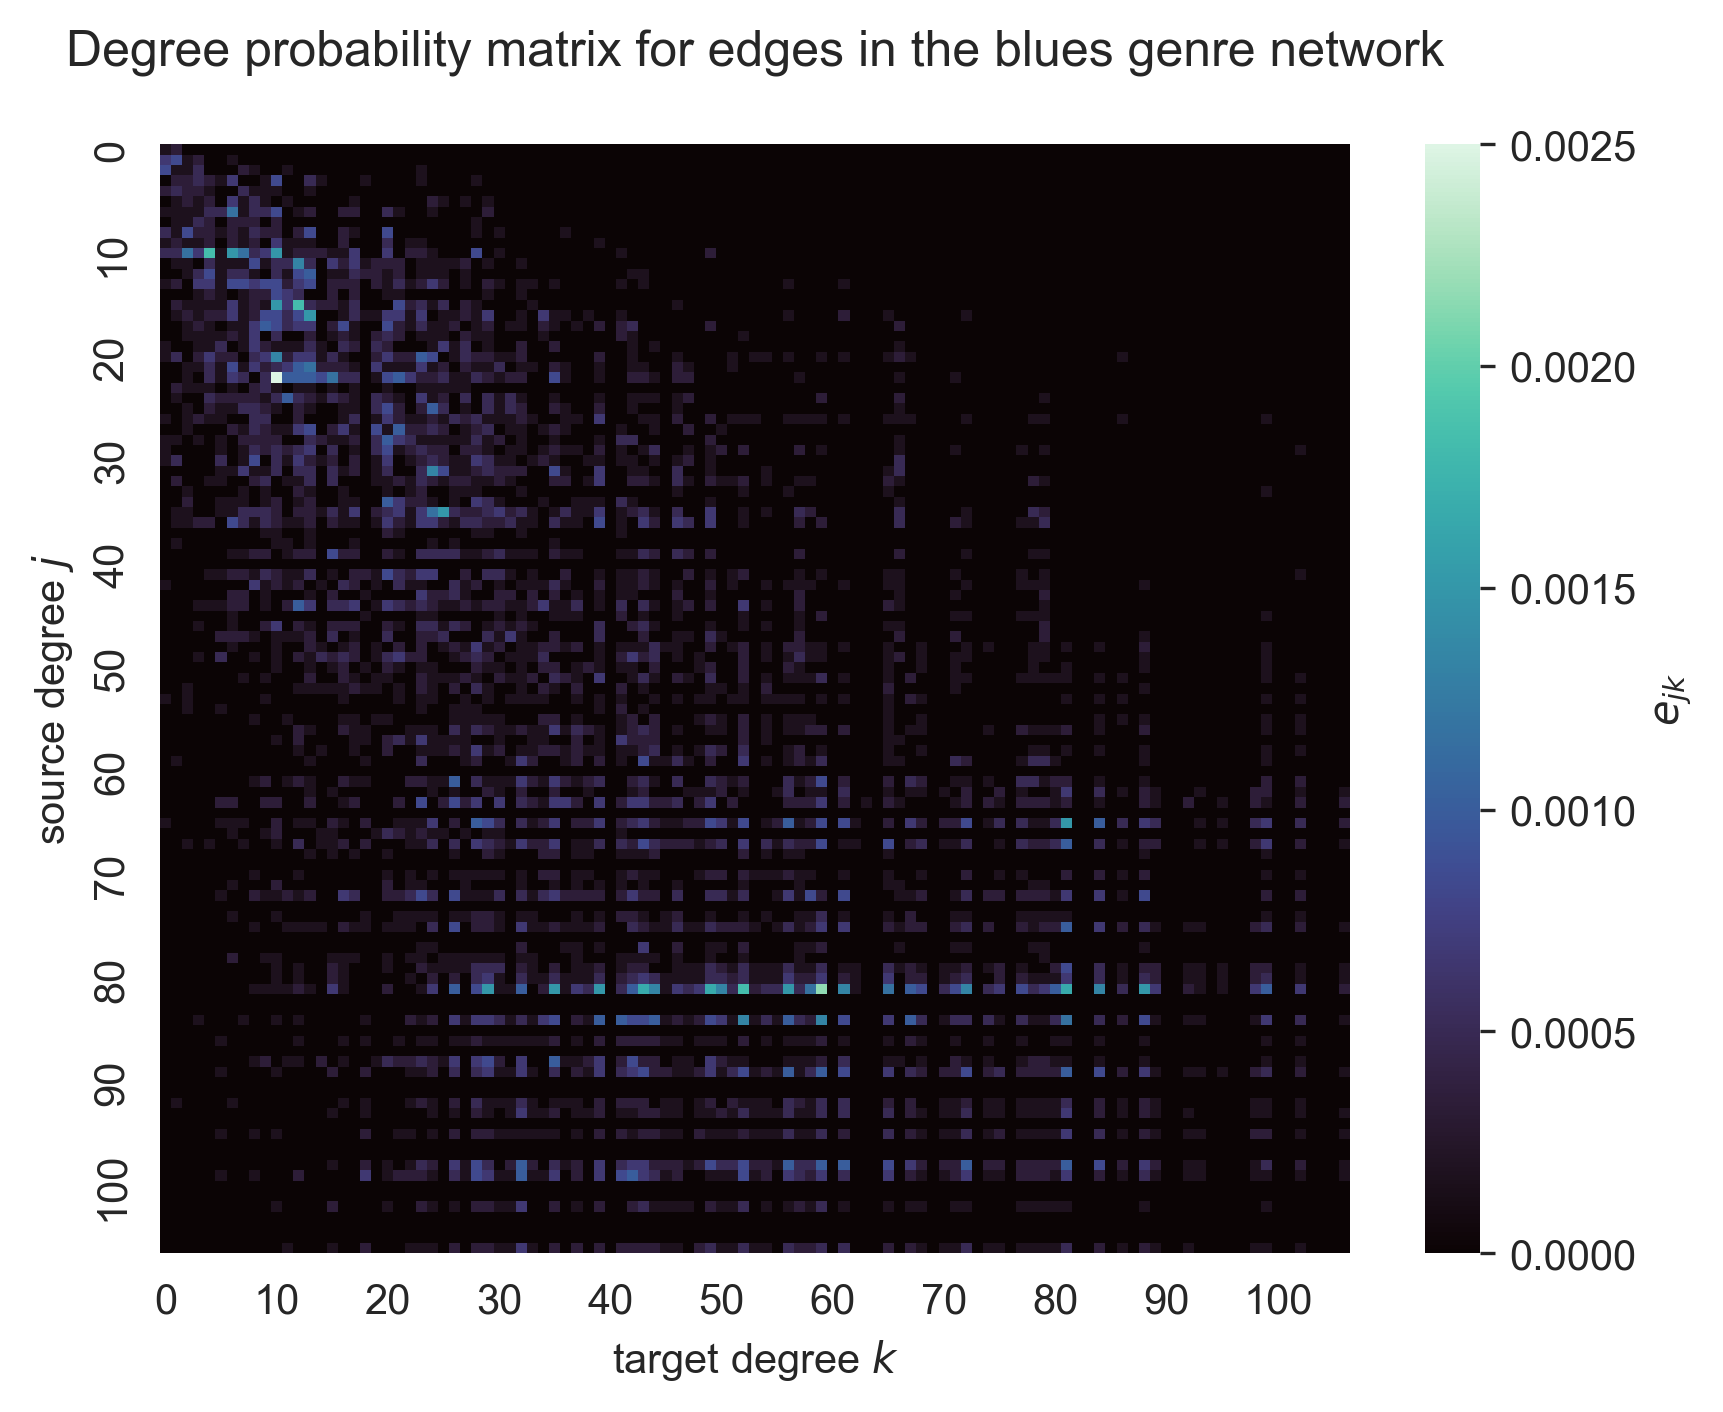

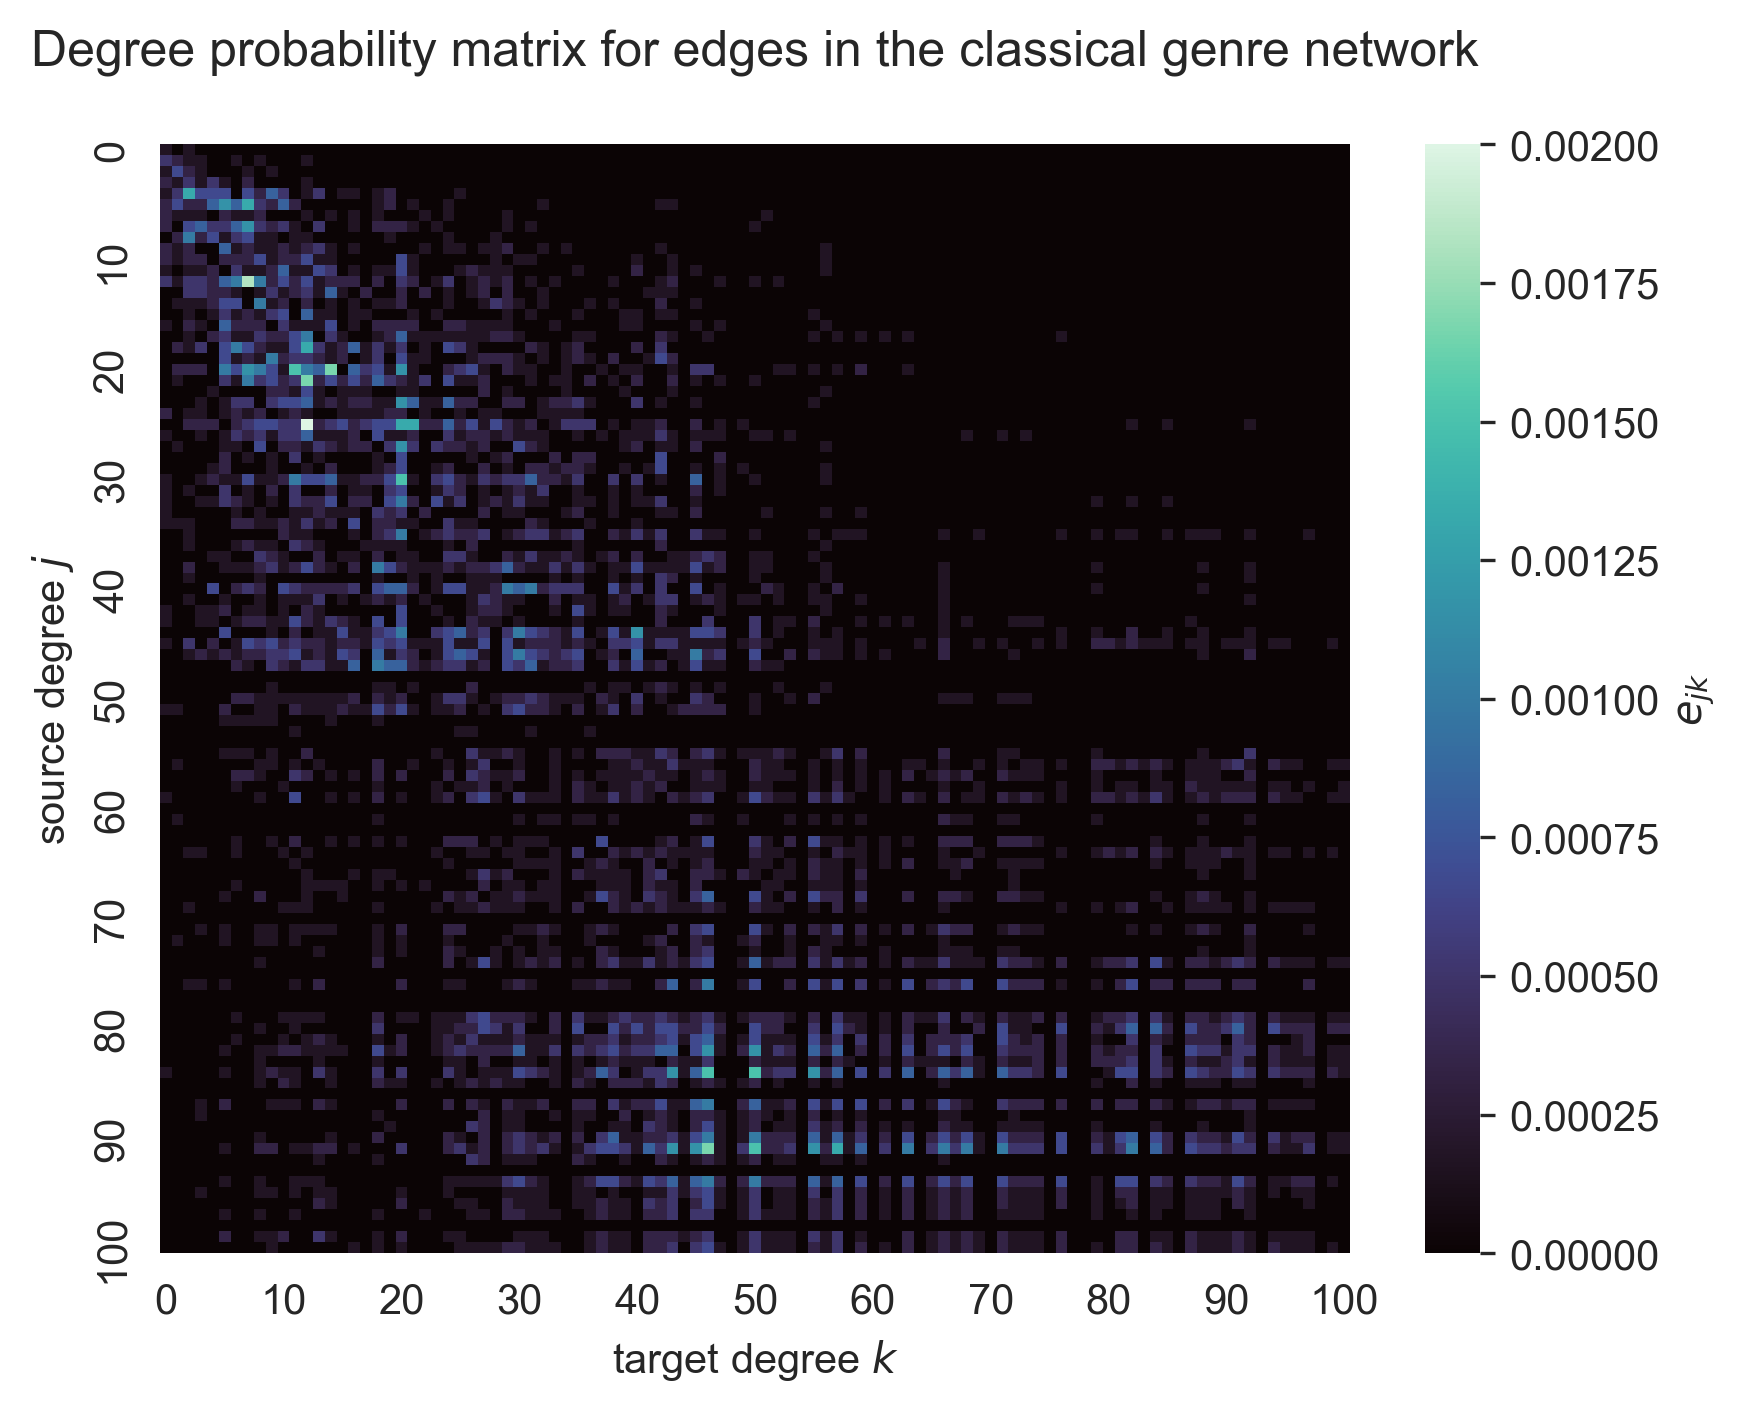

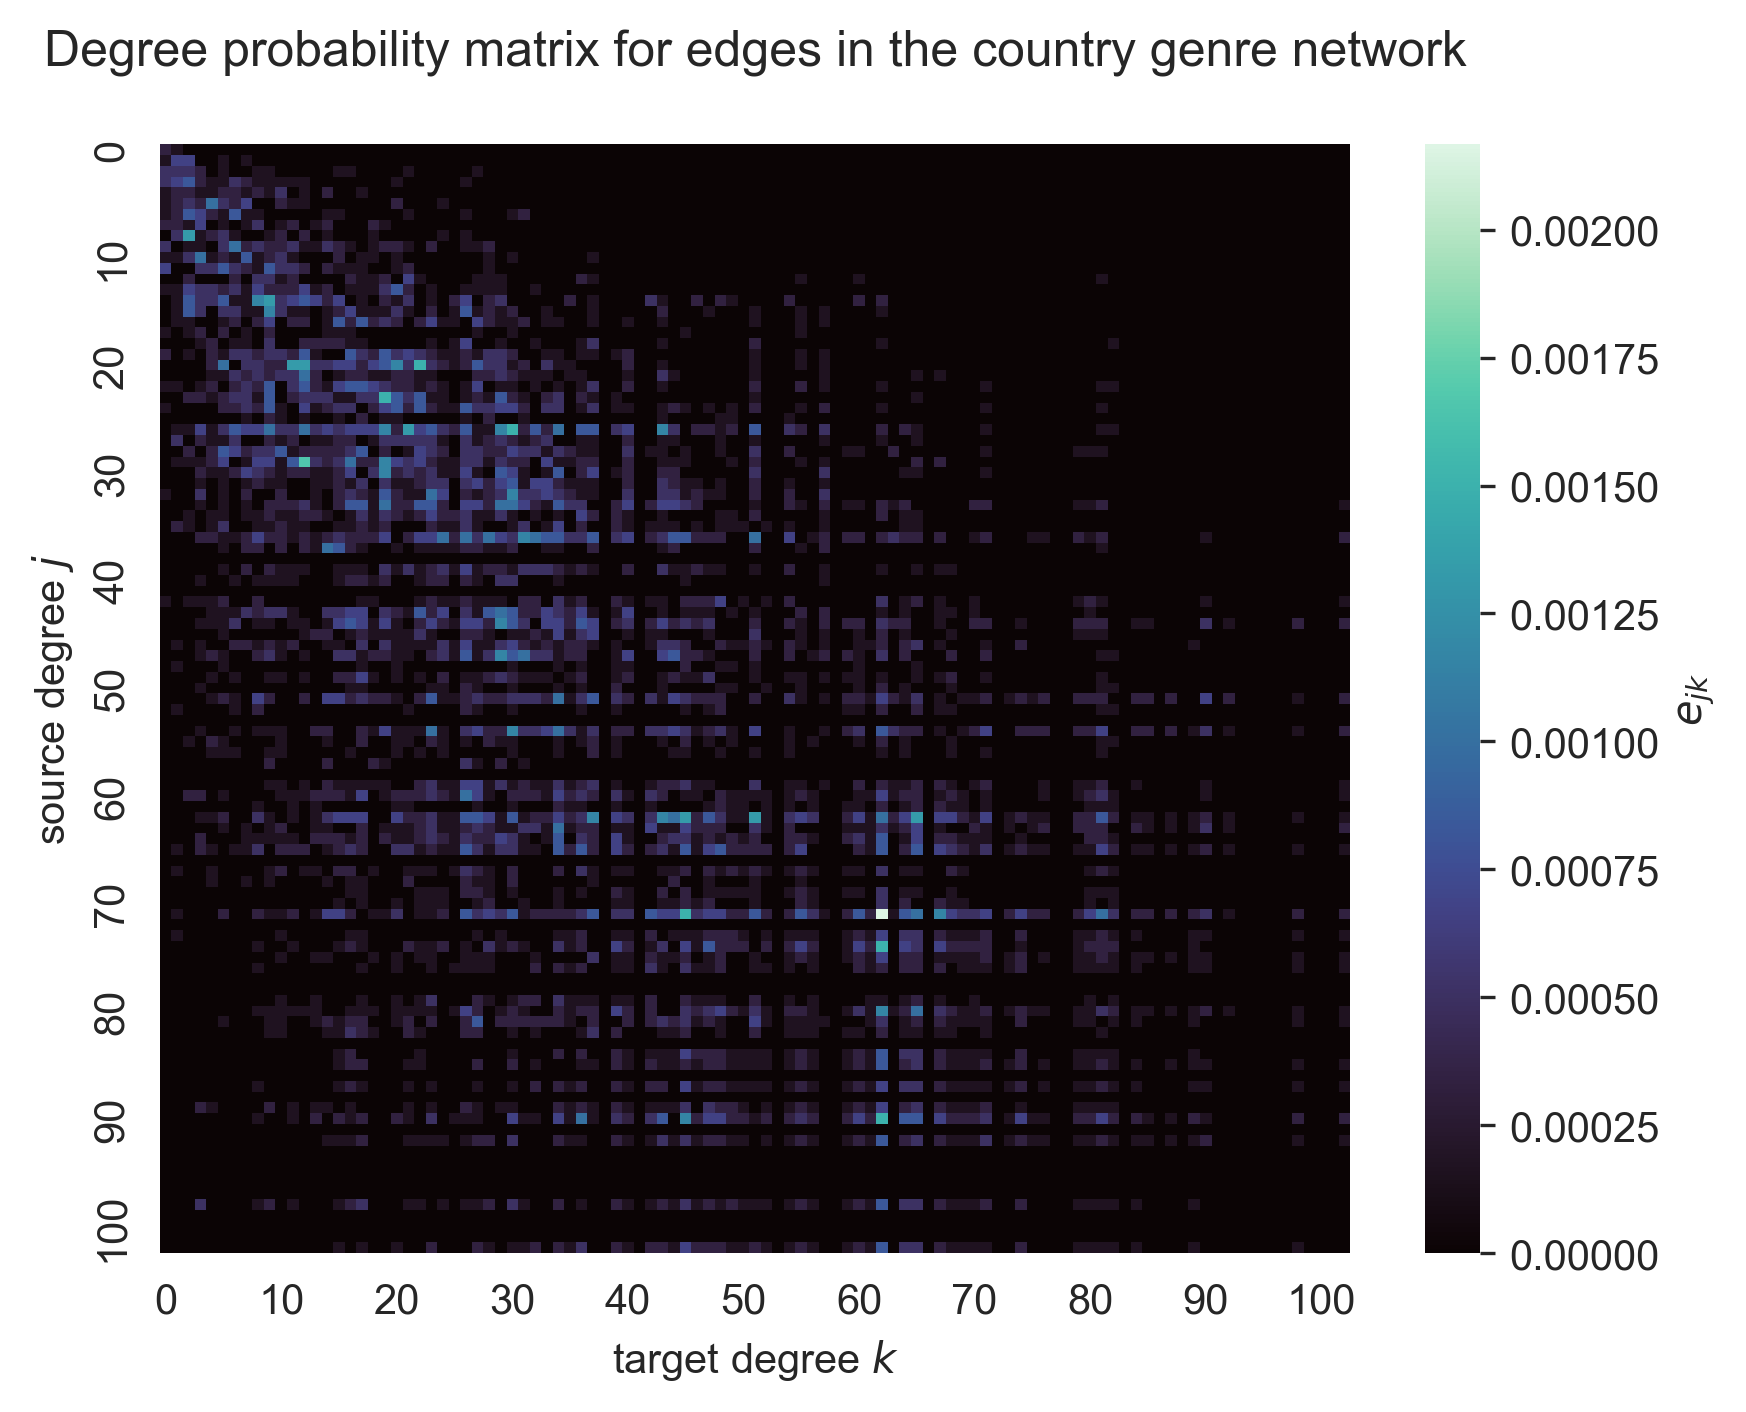

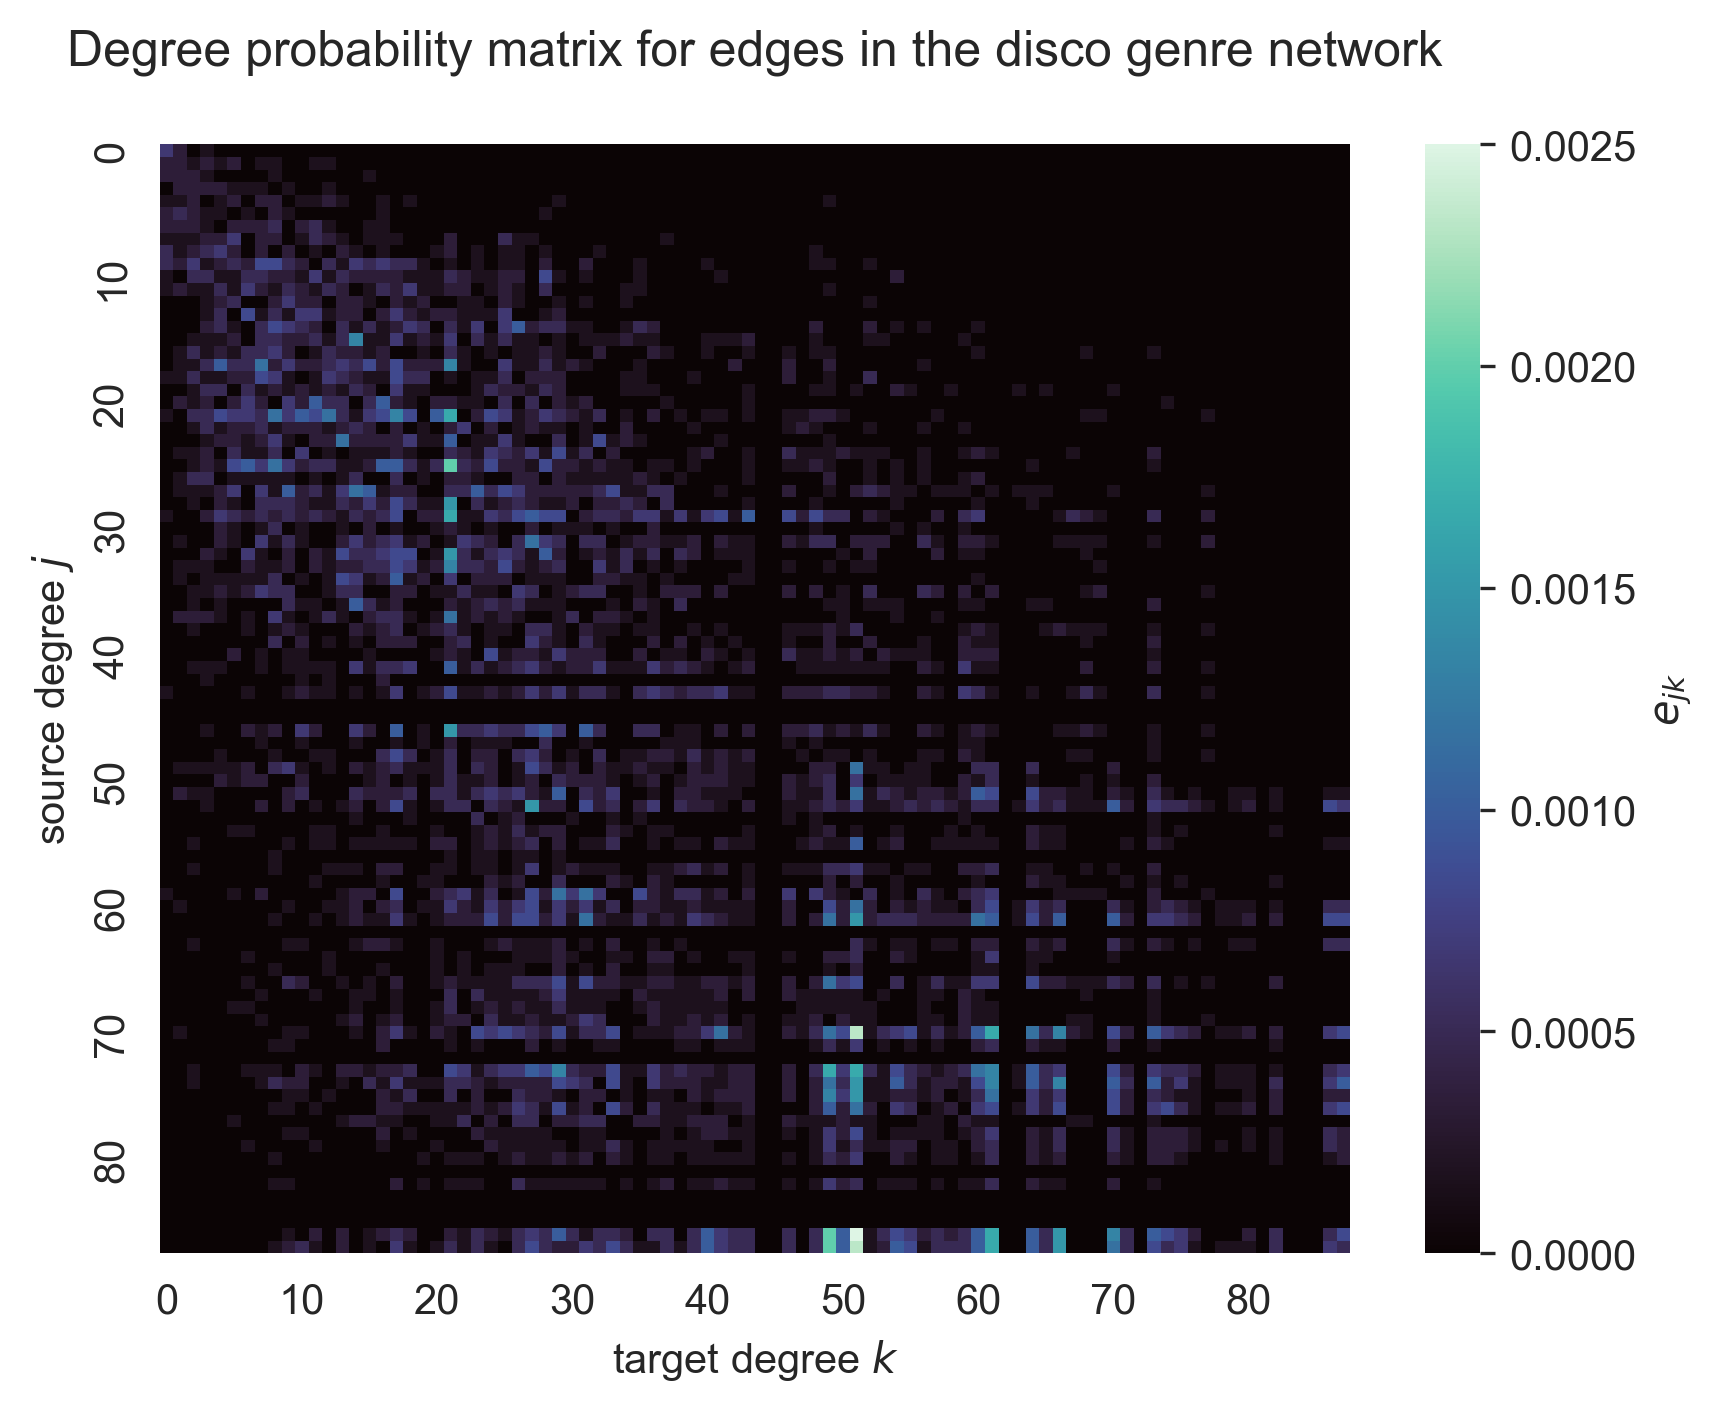

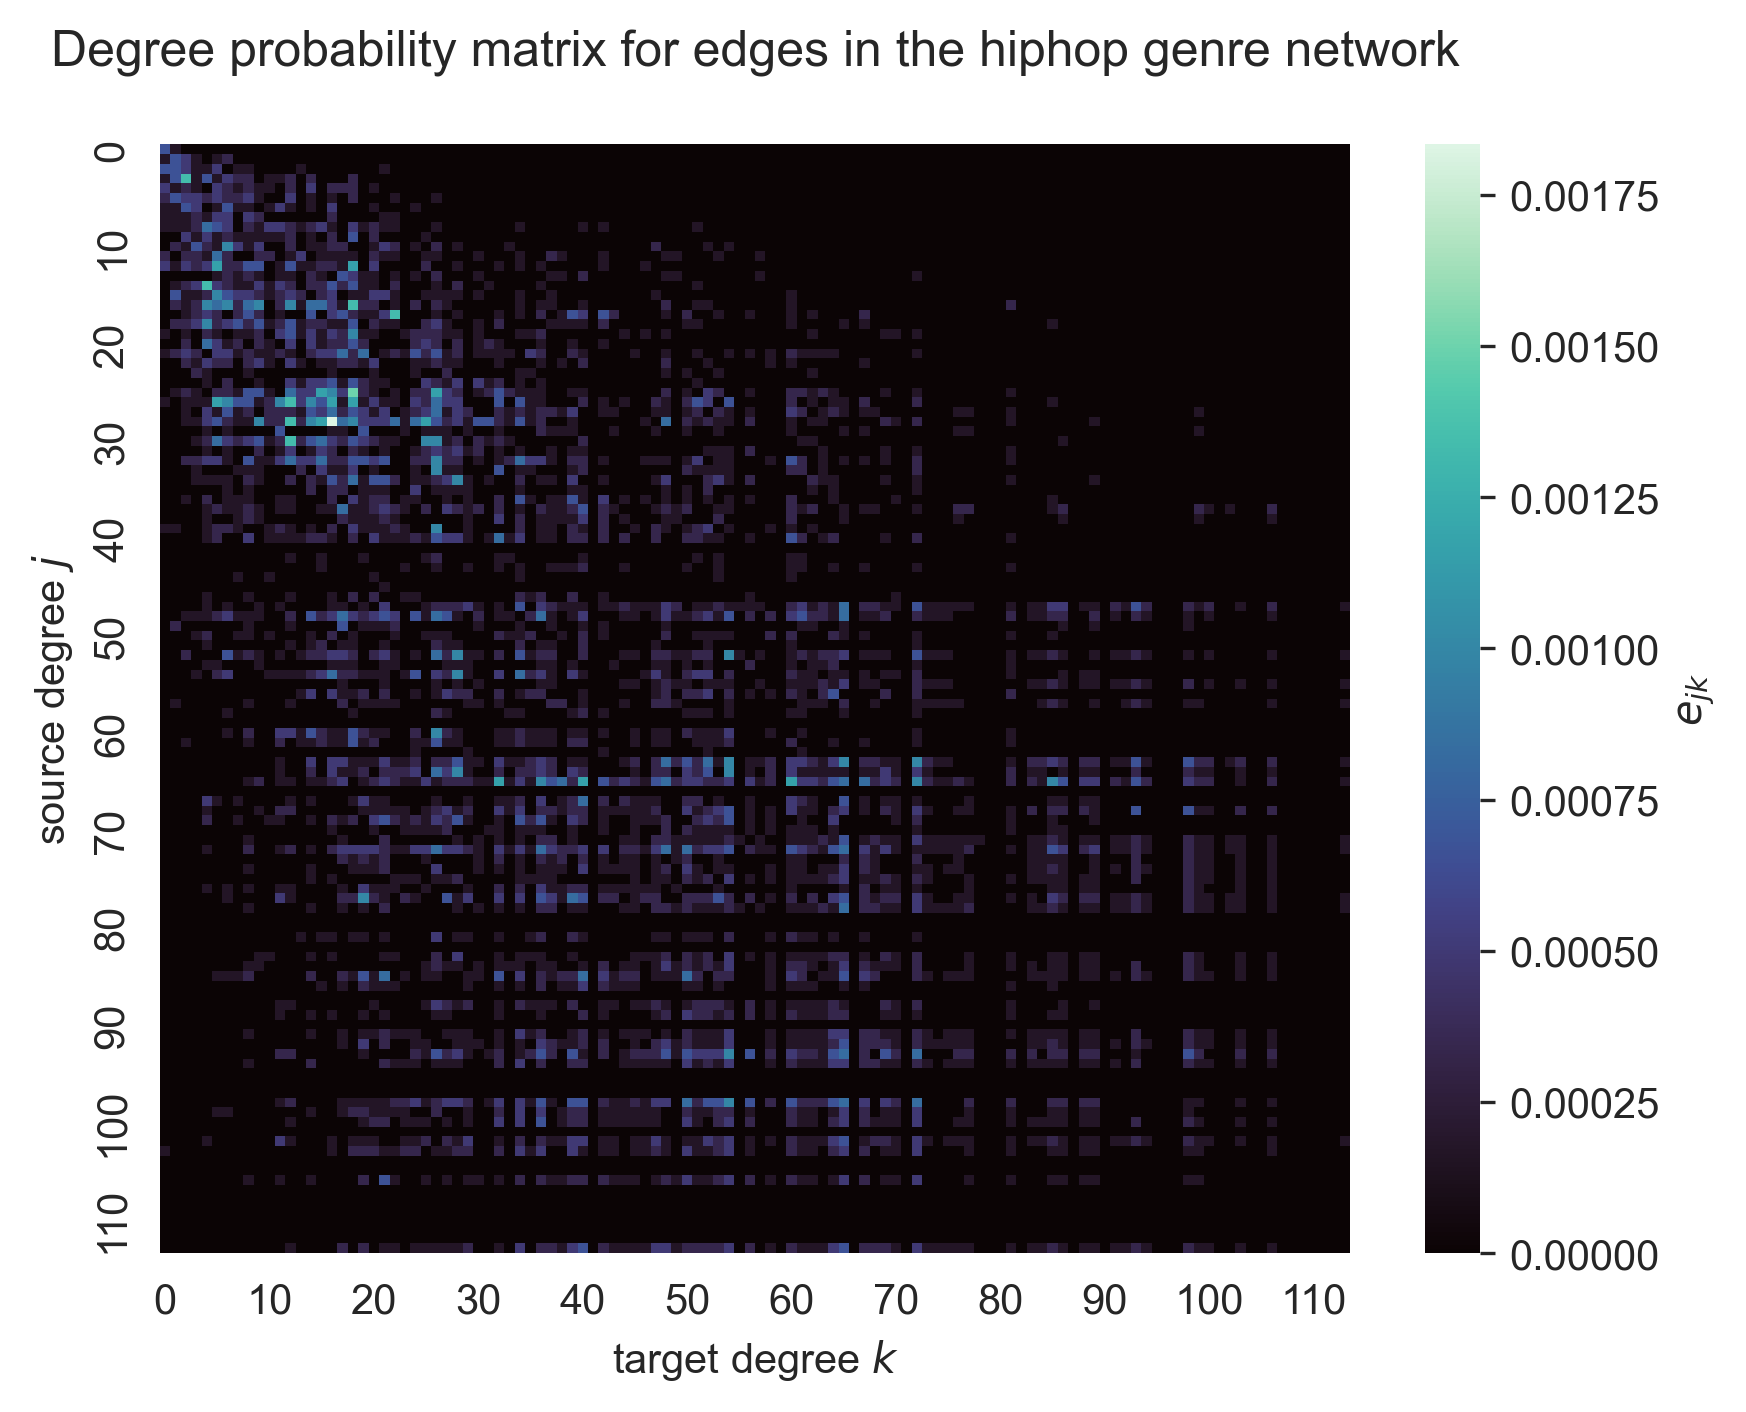

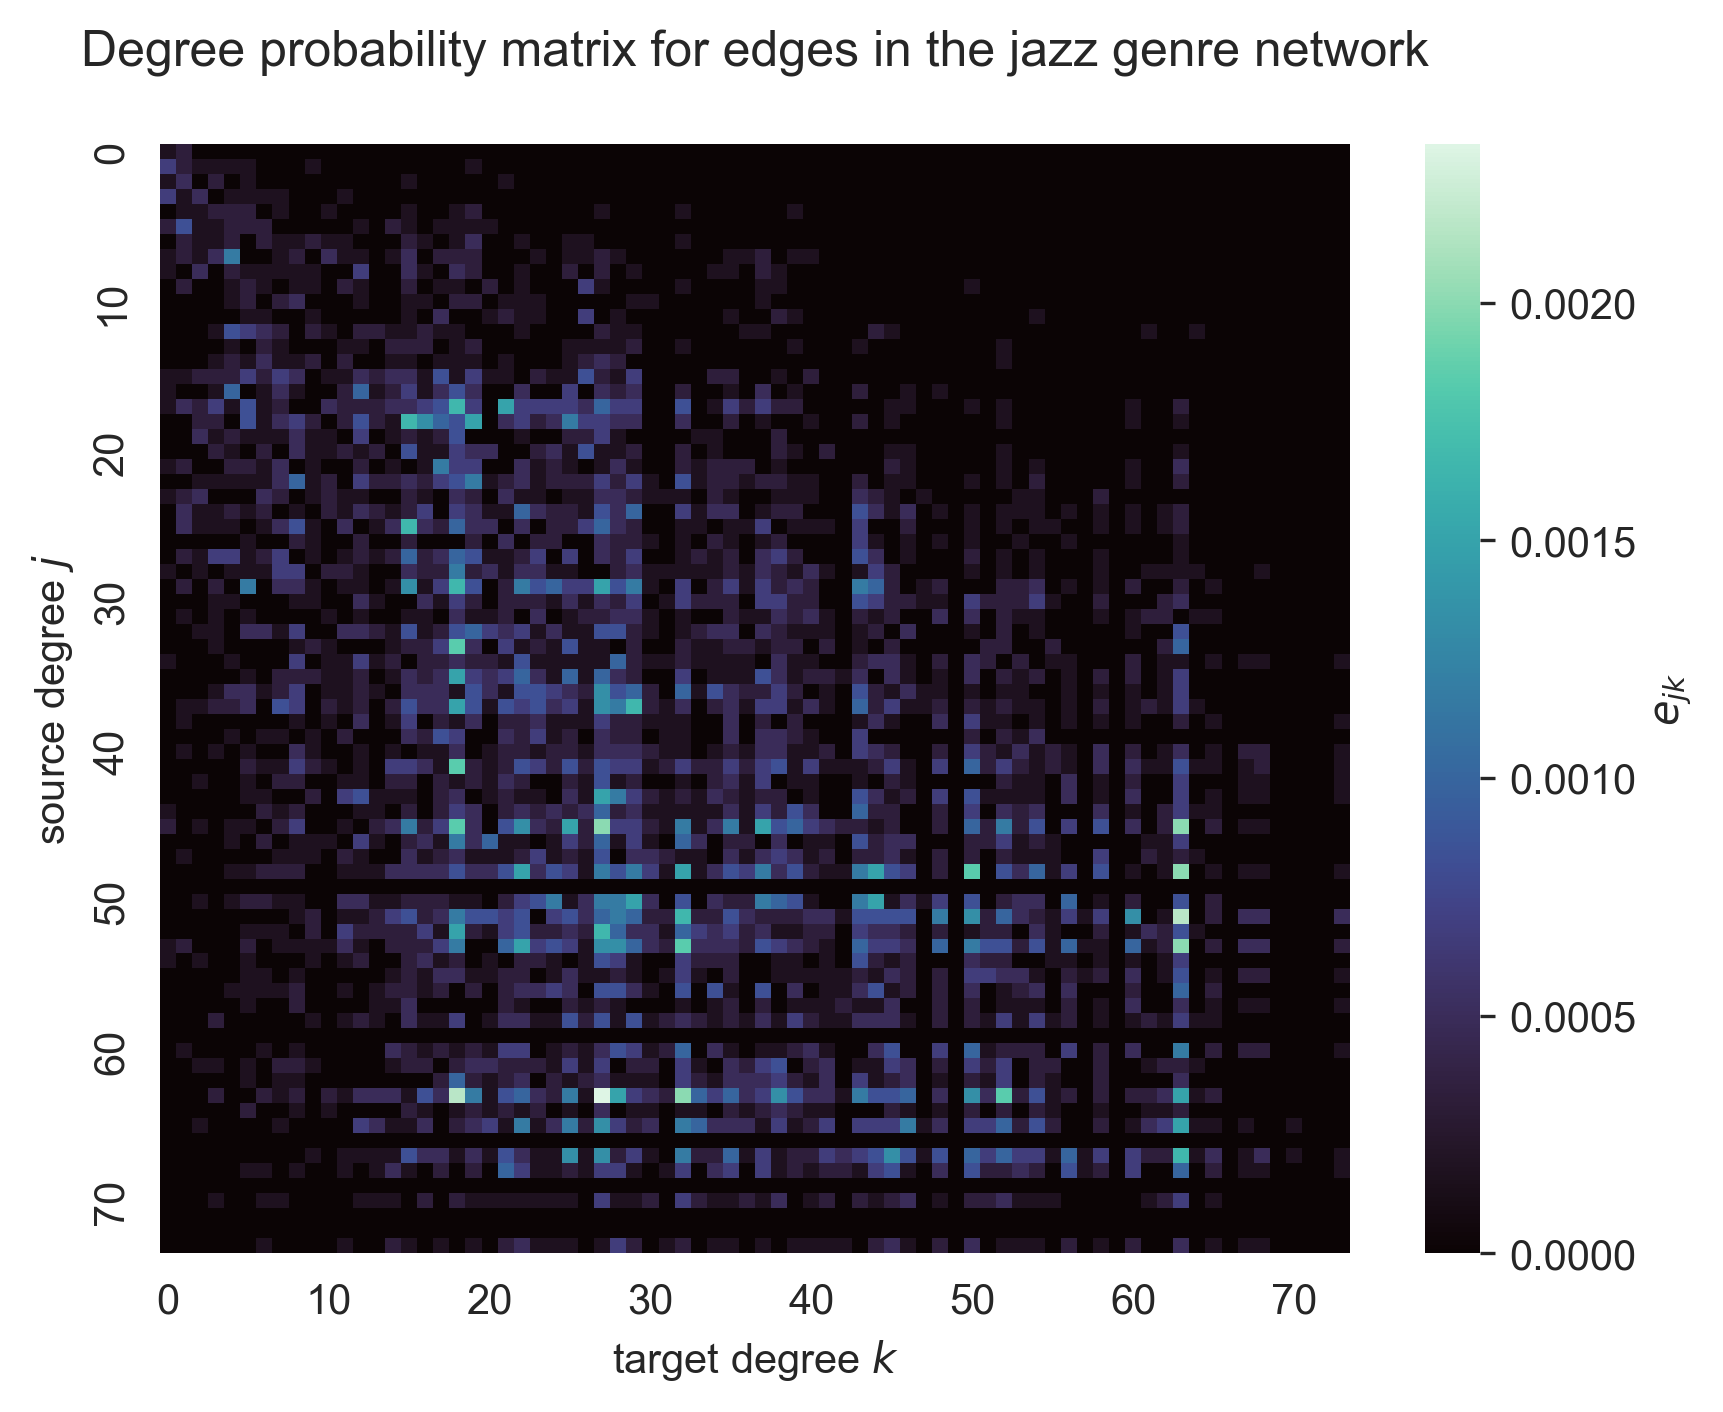

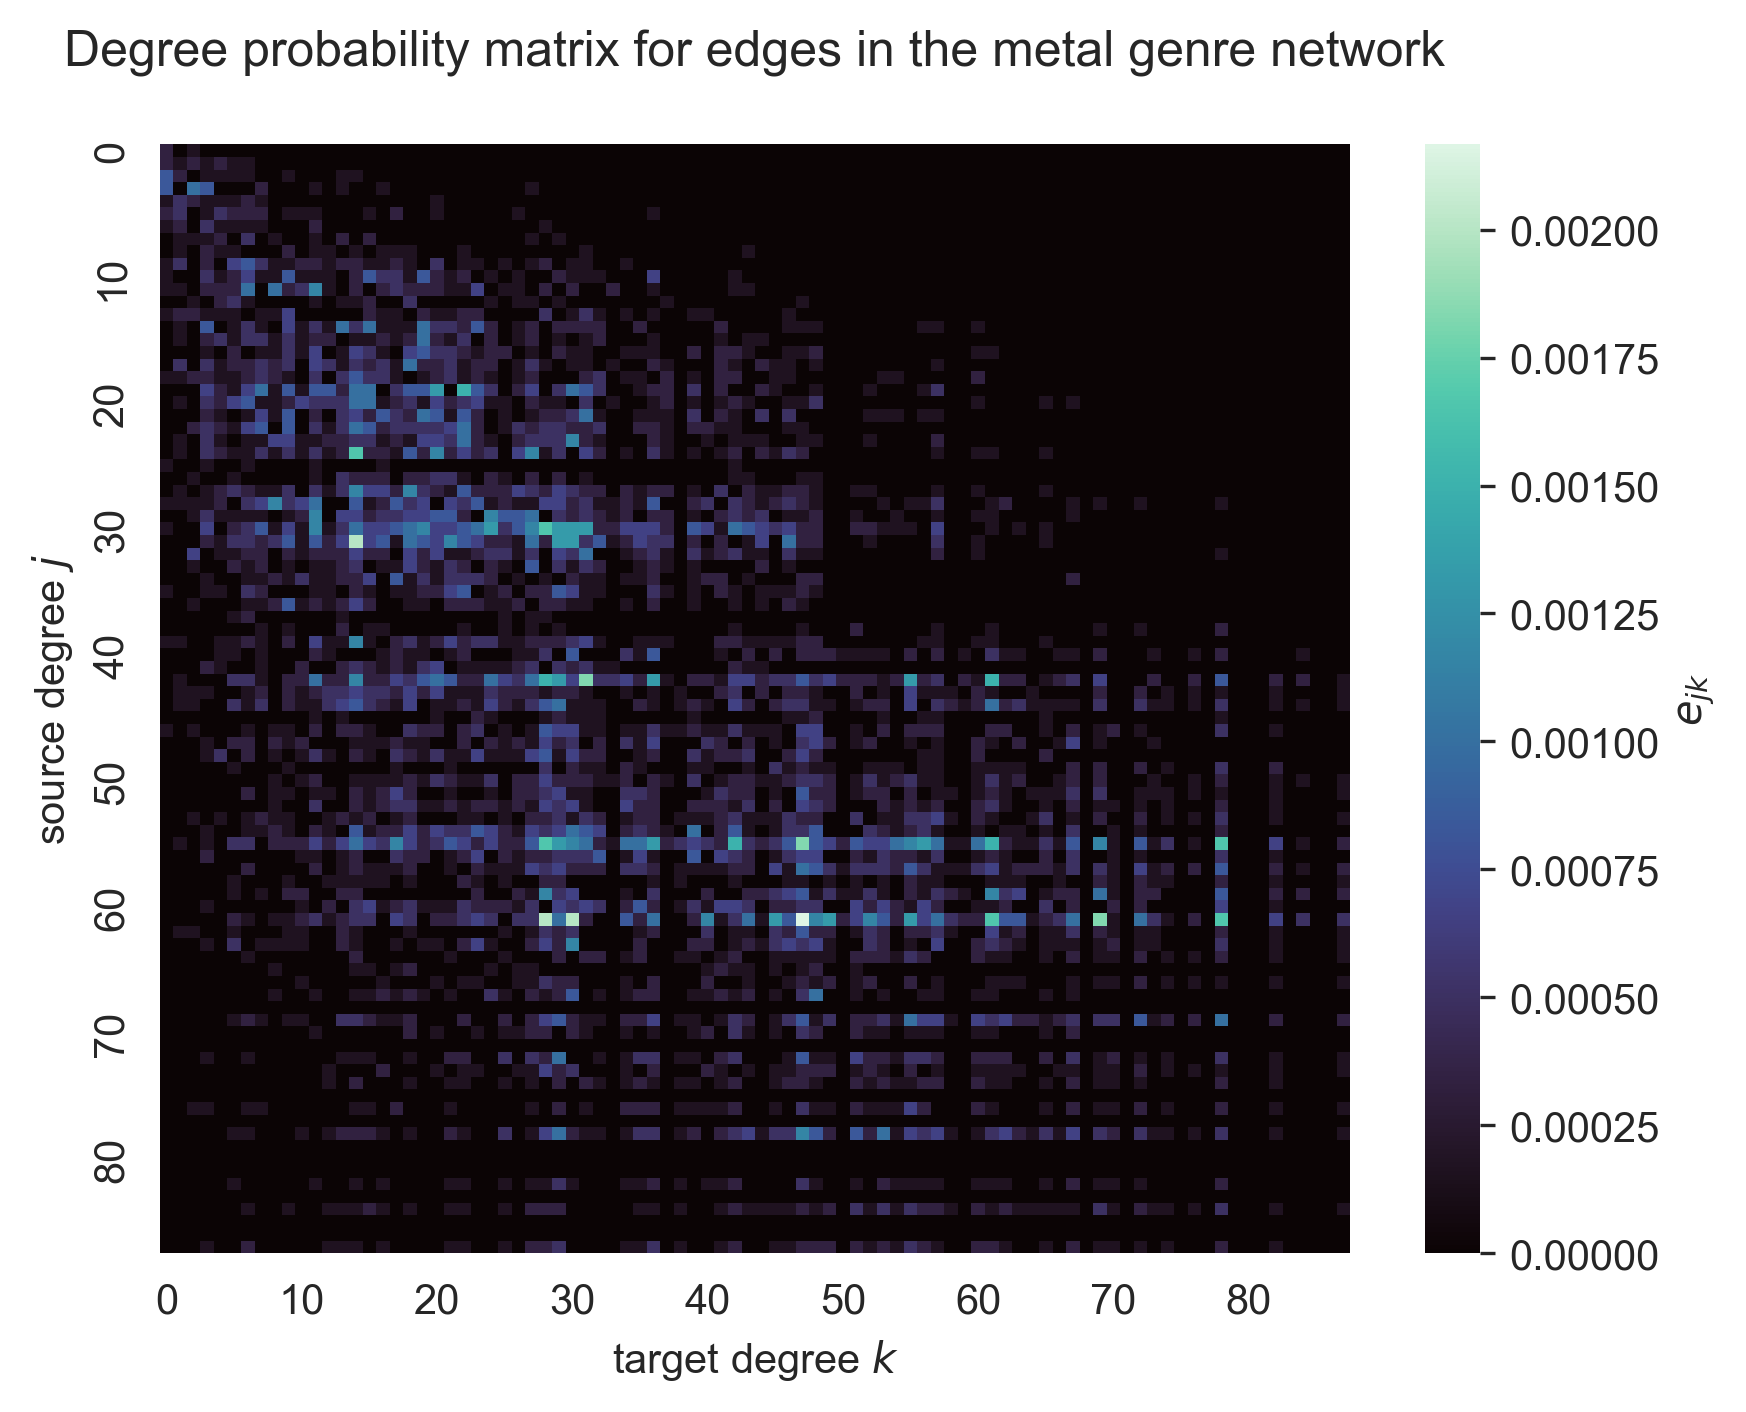

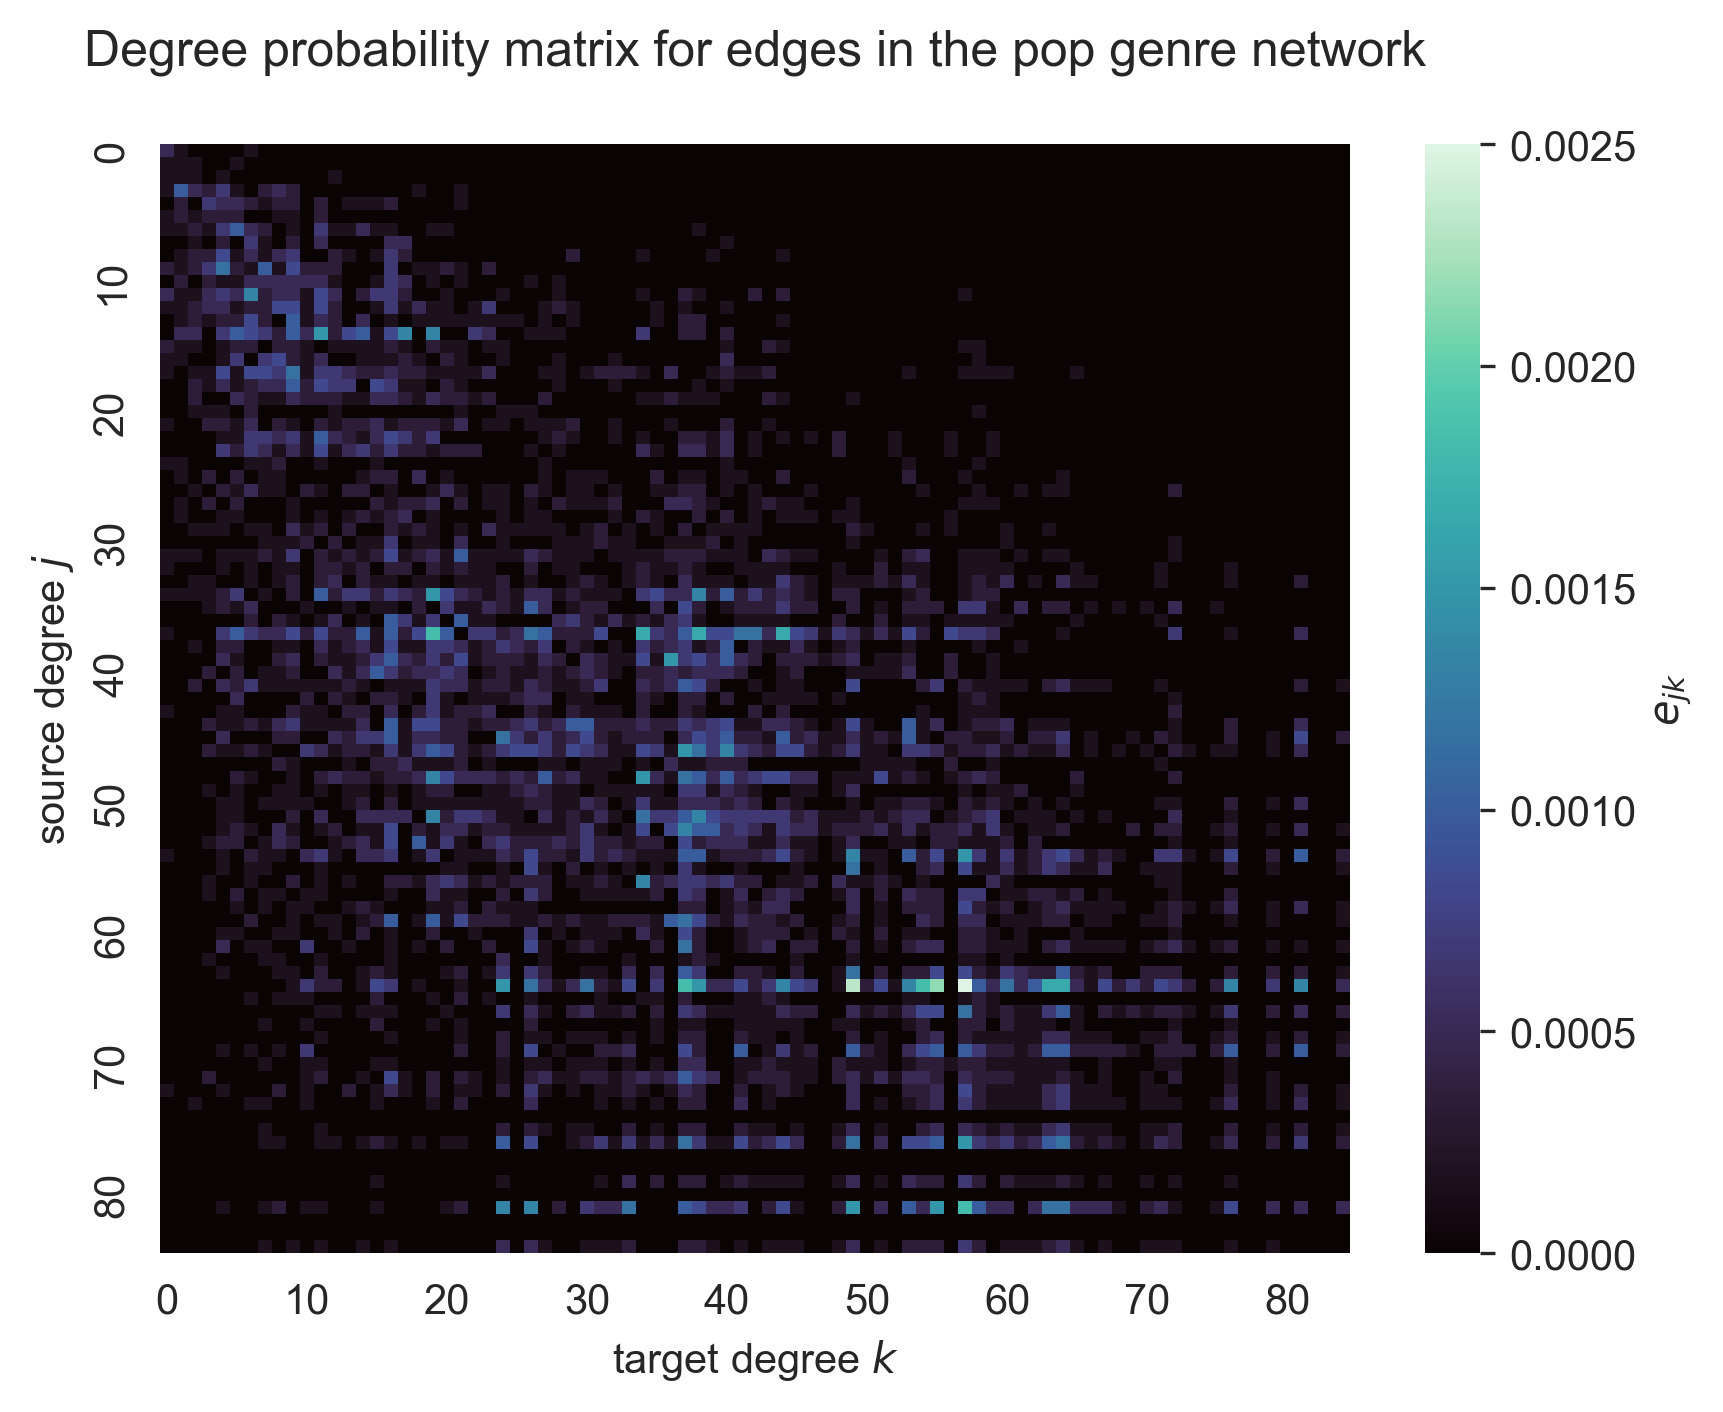

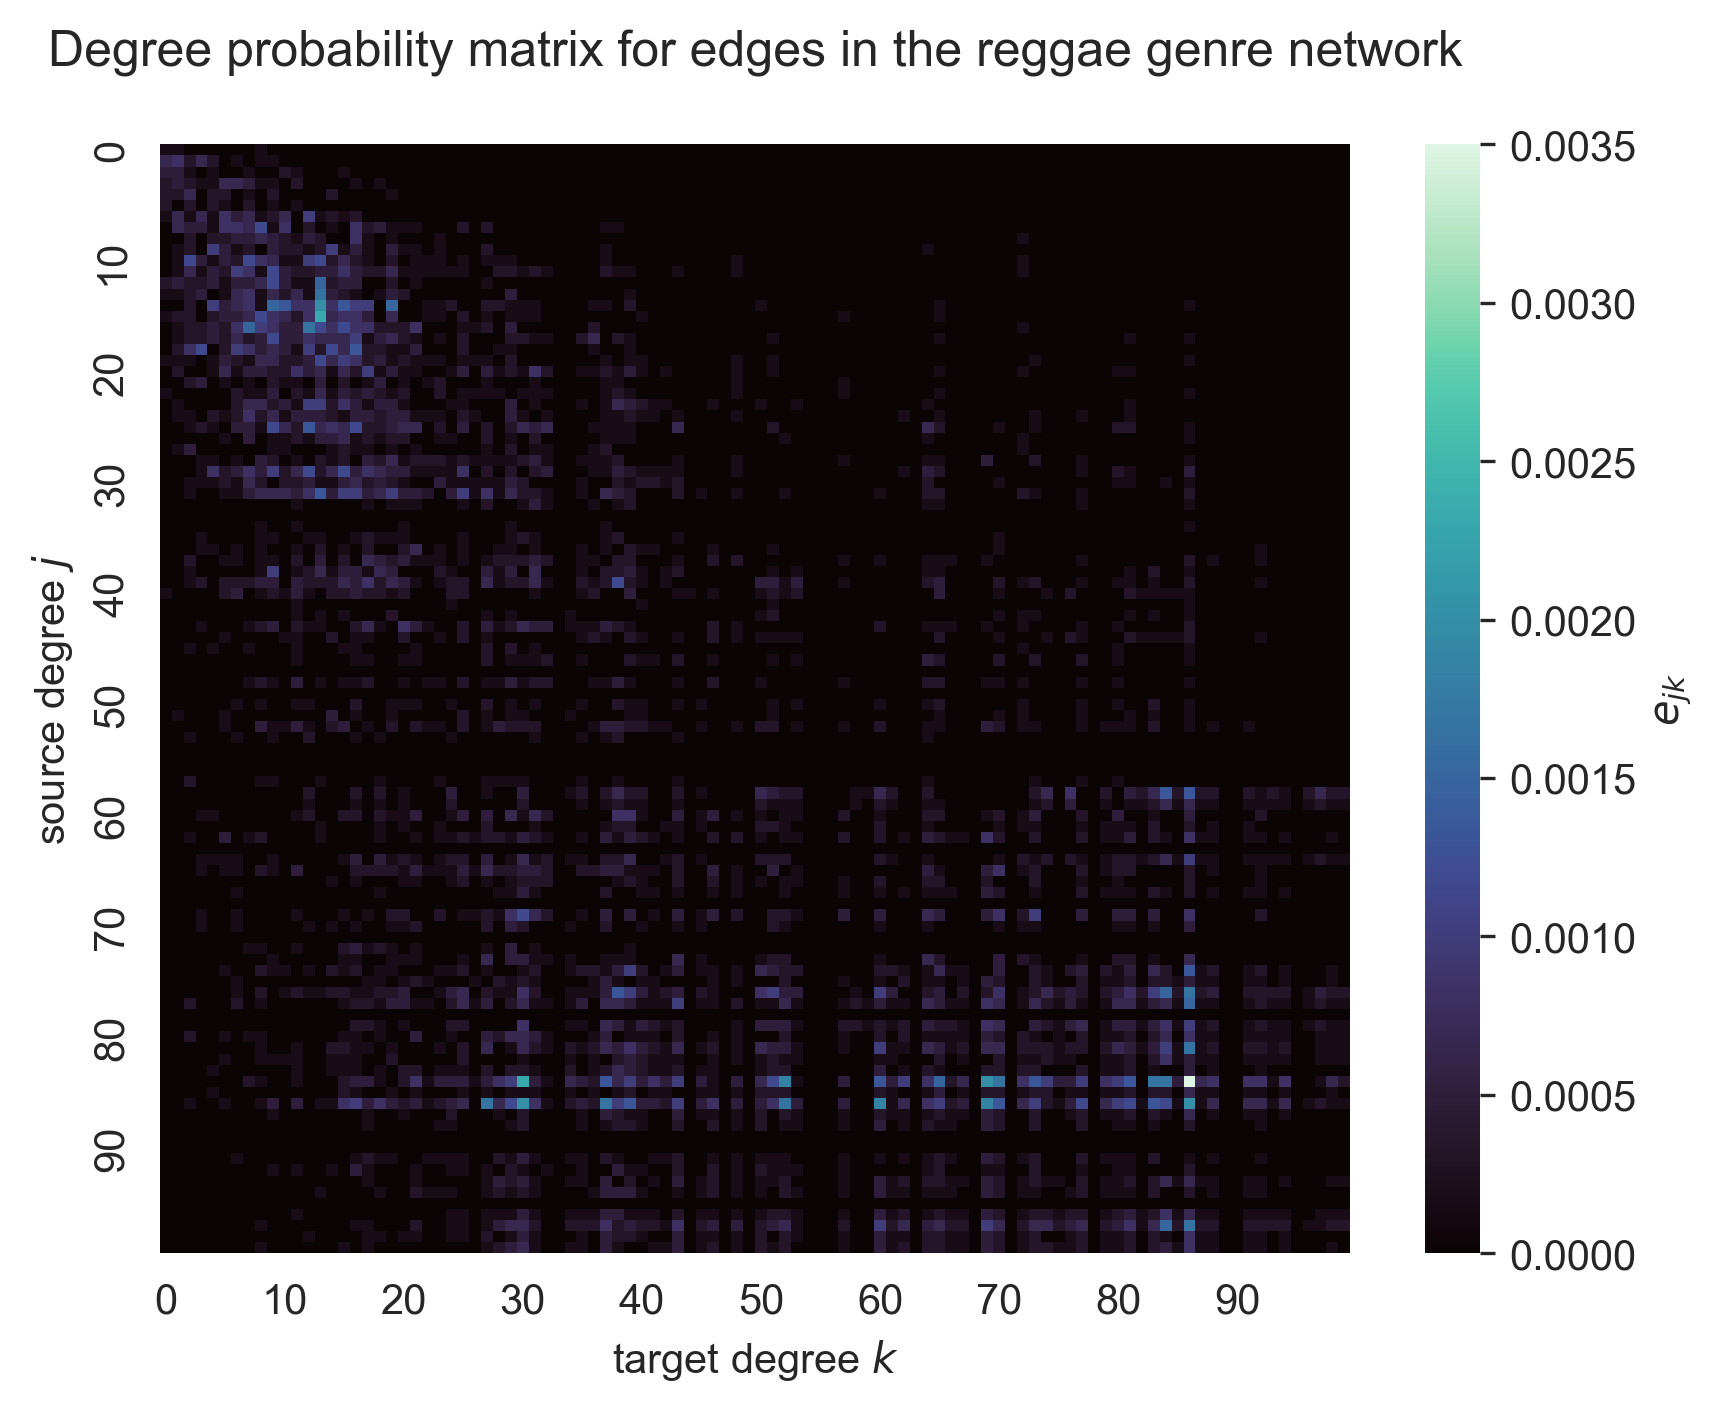

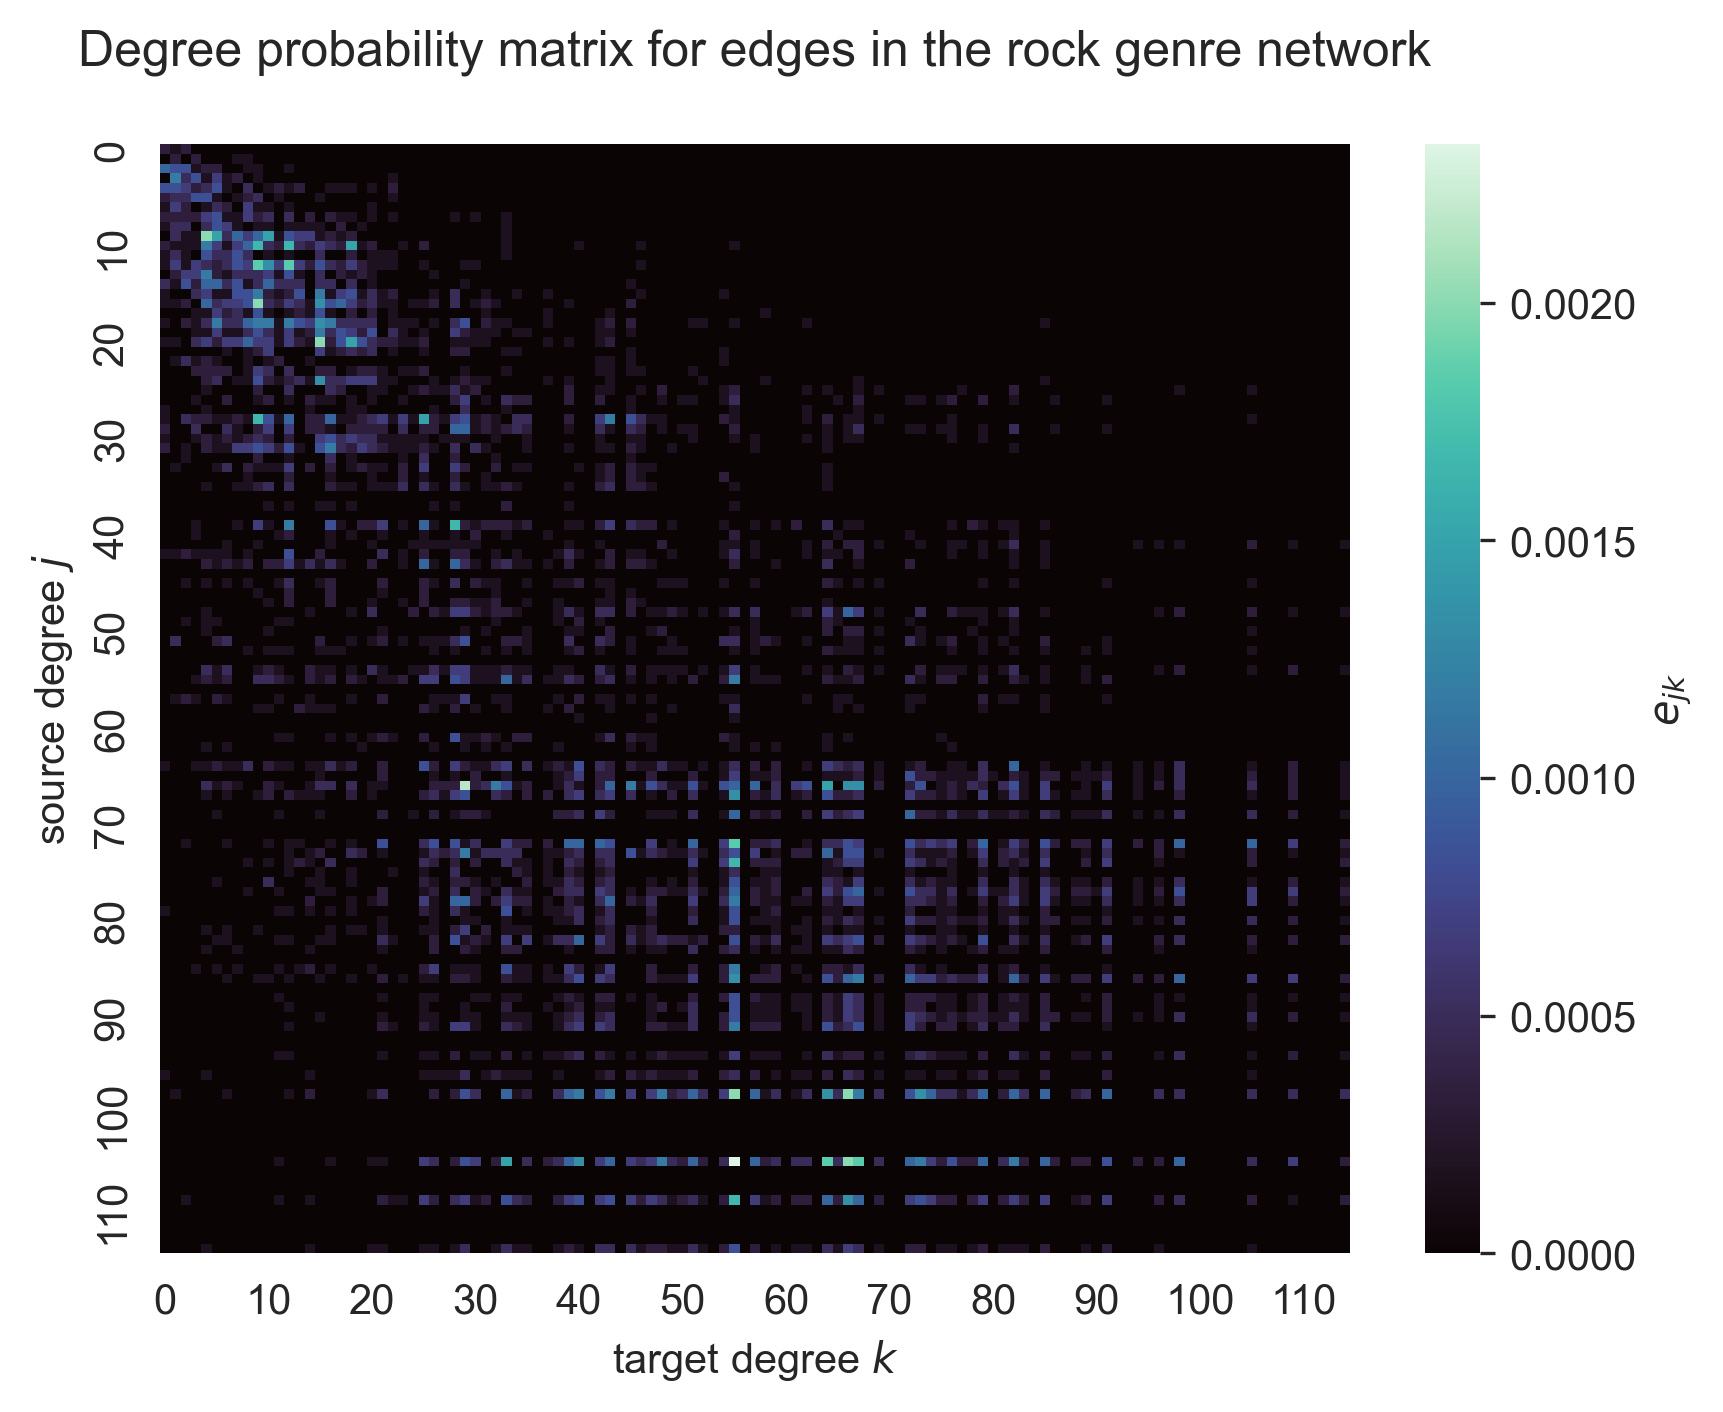

In [54]:
degree_correlation_metrics()